# Computational Astrophysics 23-24
## Project track: Collisionless N-body simulations 
### Project-3: Tidal disruptions of a Plummer model 

## I Miloncini 

| Last Name | First Name | Student Number |
|-----------|------------|----------------|
|Bertinelli |Gabriele    |2103359         |
|Bonato     |Diego       |2091250         |
|Di Prima   |Giacomo     |2086992         |
|Viterbo    |Giuseppe    |2086516         |


In this Jupyter we reported the code to perform the Analysis and the plots presented in the Report

In [1]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from matplotlib.pyplot import cm
import matplotlib as mpl
plt.rcParams.update({'font.size': 10})
from matplotlib.patches import Ellipse, Circle
import matplotlib.transforms as transforms
import pandas as pd
import scipy as sp
import astropy as ap
from tqdm.notebook import tqdm
from sklearn.cluster import DBSCAN
from scipy.interpolate import splprep, splev
from scipy.stats import gaussian_kde
from math import isnan


from fireworks.particles import Particles
import fireworks.nbodylib.nunits as NU
import fireworks.nbodylib.potentials as fnp
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni

In [2]:
def cyl_coord(pos, vel):
    rho = np.sqrt(pos[..., 0]**2 + pos[..., 1]**2)
    phi = np.arctan2(pos[..., 1], pos[..., 0])
    phi = np.where(phi < 0, phi + 2*np.pi, phi)

    vel_r = vel[...,0]*np.cos(phi) + vel[...,1]*np.sin(phi)
    vel_phi = -vel[...,0]*np.sin(phi) + vel[...,1]*np.cos(phi)
    vel_z = vel[...,2]
    
    return rho, phi, vel_r, vel_phi, vel_z


In [3]:
#single run 
N = 1000
initial_position = 10    #pos del 
M_G = 1e3    # mass of the galaxy
e = 0.5
t = 0.01
semi_major_axis = initial_position/(1-e)
data = np.load(f'Orbit/Galactic_FoR/{N}_InitialPos_{initial_position}_e_{e}_t_{t}.npy')
position = data[:, :, :3]
velocity = data[:, :, 3:6]
mass = data[:, :, 6]
energy = data[:, 0, 7]
potential = data[:, :, 8]

# Tidal radius and iterative calculation of the center of mass 

In [4]:
def flag_cluster(position: npt.NDArray[np.float64], velocity: npt.NDArray[np.float64], mass: npt.NDArray[np.float64], N: int, M_G: float):
    
    """
    Function to find the stars that are bound to the cluster. Create a flag array with the same length as the number of stars
    in the cluster. The flag array is set to True for the stars that are bound to the cluster and False for the stars that are
    unbound. The function returns the flag array, the center of mass of the cluster and the tidal radius of the cluster.

    Parameters
    ----------
    position : npt.NDArray[np.float64]
        Array with the positions of the stars at each snapshot

    velocity : npt.NDArray[np.float64]
        Array with the velocities of the stars at each snapshot

    mass : npt.NDArray[np.float64]
        Array with the mass of the stars at each snapshot

    N : int
        Number of stars in the cluster

    M_G : float
        Mass of the galaxy
    """

    flag_history = []
    com_history = []
    vel_com_history = []
    tidal2_history = []

    flag = np.ones(N, dtype=bool)
    for snapshot in tqdm(range(len(position))):
        pos_snap, vel_snap = position[snapshot], velocity[snapshot]

        current_flag = np.zeros(N, dtype=bool)
        k = 0
        while flag.sum() - current_flag.sum() != 0:
            if k>100:
                break
            current_flag = flag.copy()
            if mass[snapshot][flag].sum() == 0:
                pos_com_snap = np.average(pos_snap[flag], axis=0)
                vel_com_snap = np.average(vel_snap[flag], axis=0)
            else:
                pos_com_snap = np.average(pos_snap[flag], axis=0, weights=mass[snapshot][flag])
                vel_com_snap = np.average(vel_snap[flag], axis=0, weights=mass[snapshot][flag])


            # Calculate distances to the center of mass
            distances_to_com = np.sqrt(np.sum((pos_snap - pos_com_snap)**2, axis=1))

            # Calculate tidal radius
            r_t = np.linalg.norm(pos_com_snap) * (np.sum(mass[snapshot][flag]) / M_G) ** (1 / 3)

            # Update flag based on tidal radius
            flag = distances_to_com < 2*r_t

        flag_history.append(flag)
        com_history.append(pos_com_snap)
        vel_com_history.append(vel_com_snap)
        tidal2_history.append(2*r_t)

    return flag_history, com_history, vel_com_history, tidal2_history


In [5]:
flag_history, com_history, vel_com_history, tidal2_history = flag_cluster(position, velocity, mass, N, M_G)

  0%|          | 0/2340 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/root/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


# Distance between true CoM and iterative CoM in tidal radius

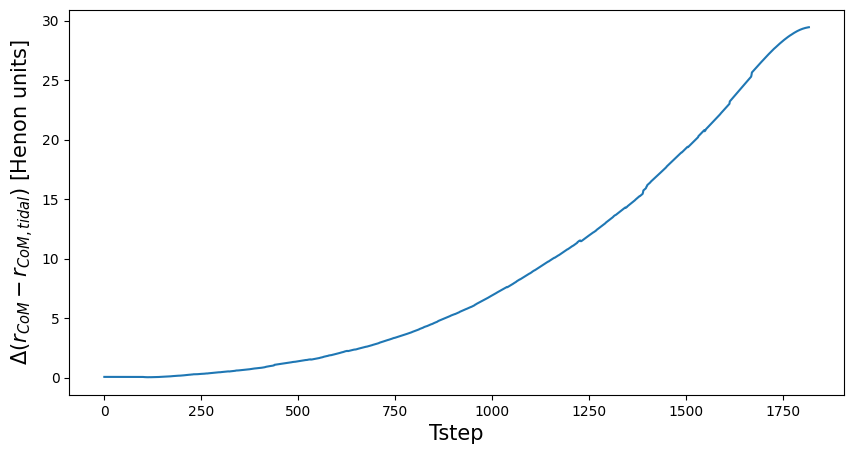

In [6]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.plot(np.linalg.norm(np.array(com_history) - position[:].mean(axis=1), axis=1))
ax.set_xlabel('Tstep', fontsize=15)
ax.set_ylabel(r'$\Delta (r_{CoM} - r_{CoM, tidal})$ [Henon units]',fontsize=15)
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/Delta_r_tidal_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

# Analysis considering only the stars inside the tidal radius

### %_mass_radius

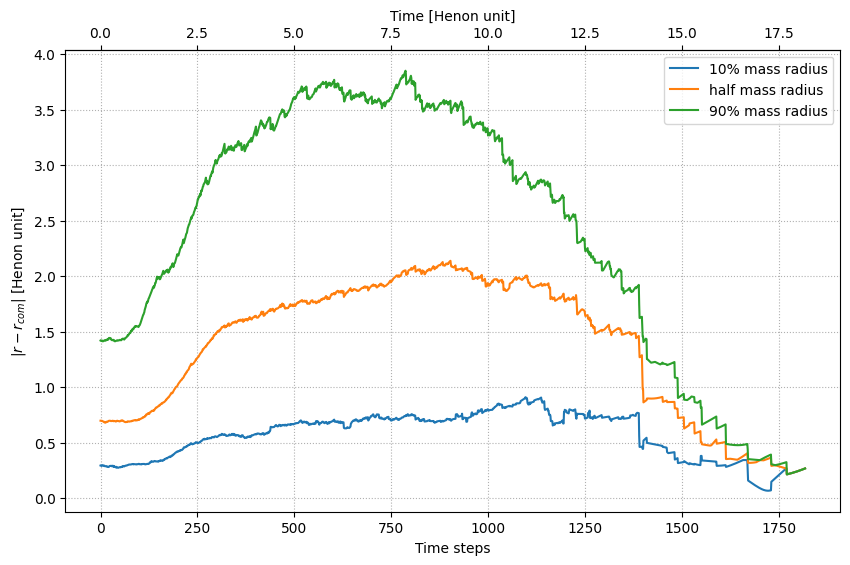

In [7]:
position_comFoR = np.zeros_like(position)
for i in range(len(position)):
    position_comFoR[i] = position[i] - np.array(com_history[i])


tenperc_mass_radius = []
half_mass_radius = []
ninethyperc_mass_radius = []

for time in range(int(len(position_comFoR))):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    N_flagged = len(position_comFoR_flagged)
    current_radius = np.linalg.norm(position_comFoR[time], axis=1)
    sorted_radius = sorted(current_radius)
    tenperc_mass_radius.append(sorted_radius[int(N_flagged/10)])
    half_mass_radius.append(sorted_radius[int(N_flagged/2)])
    ninethyperc_mass_radius.append(sorted_radius[int(9*N_flagged/10)])
    
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()
ax.plot(tenperc_mass_radius, label='10% mass radius')
ax.plot(half_mass_radius, label='half mass radius')
ax.plot(ninethyperc_mass_radius, label='90% mass radius')

ax.legend()
ax.grid(linestyle='dotted')
ax.set_xlabel('Time steps')
f = lambda x: x*0.01
g = lambda x: x/0.01
ax2 = ax.secondary_xaxis("top", functions=(f, g))
ax2.set_xlabel("Time [Henon unit]")
ax.set_ylabel(r'$|r - r_{com}|$ [Henon unit]') 
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/r_perc_mass_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

## Mass loss

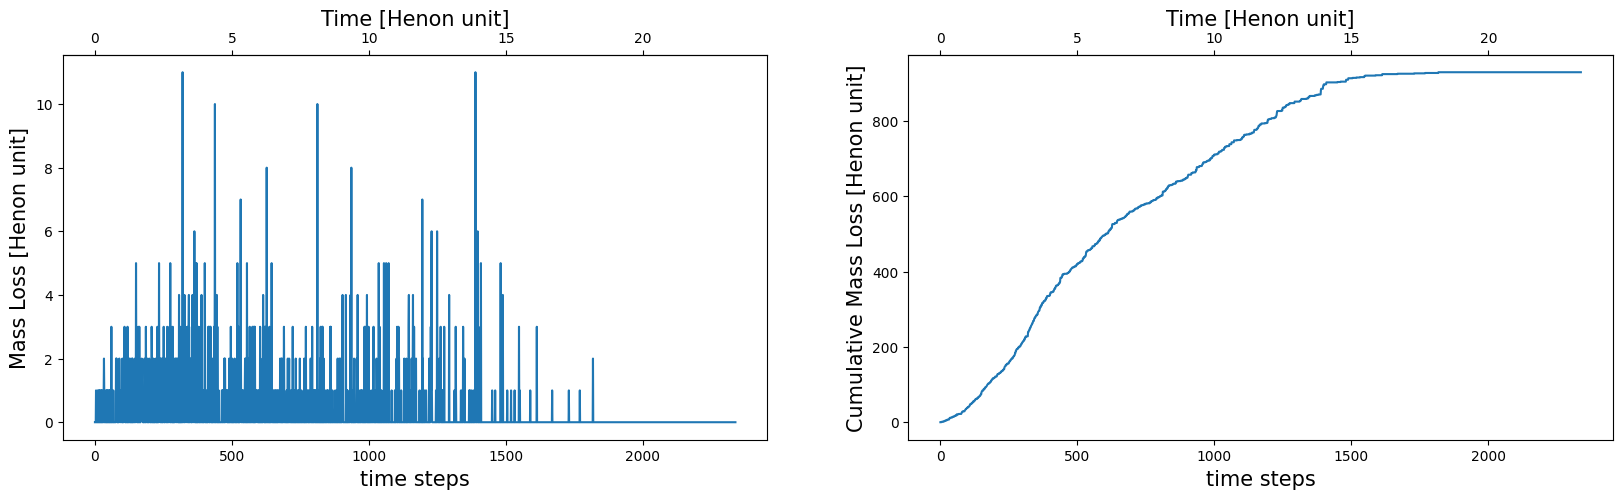

In [8]:
flag_history = np.array(flag_history)
mass_loss = abs(flag_history[1:, :].sum(axis=1) - flag_history[:-1, :].sum(axis=1))
mass_loss_cum = np.cumsum(mass_loss)

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
ax.plot( mass_loss)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Mass Loss [Henon unit]', fontsize=15)
ax.set_xlabel('time steps', fontsize=15)
f = lambda x: x*0.01
g = lambda x: x/0.01
ax2 = ax.secondary_xaxis("top", functions=(f, g))
ax2.set_xlabel("Time [Henon unit]",fontsize=15)

ax = fig.add_subplot(122)
ax.plot(mass_loss_cum)
ax.set_ylabel('Cumulative Mass Loss [Henon unit]', fontsize=15)
ax.set_xlabel('time steps',fontsize=15)
ax2 = ax.secondary_xaxis("top", functions=(f, g))
ax2.set_xlabel("Time [Henon unit]",fontsize=15)
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/MassLoss_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

### Density profile n_bins is the number of shell considered

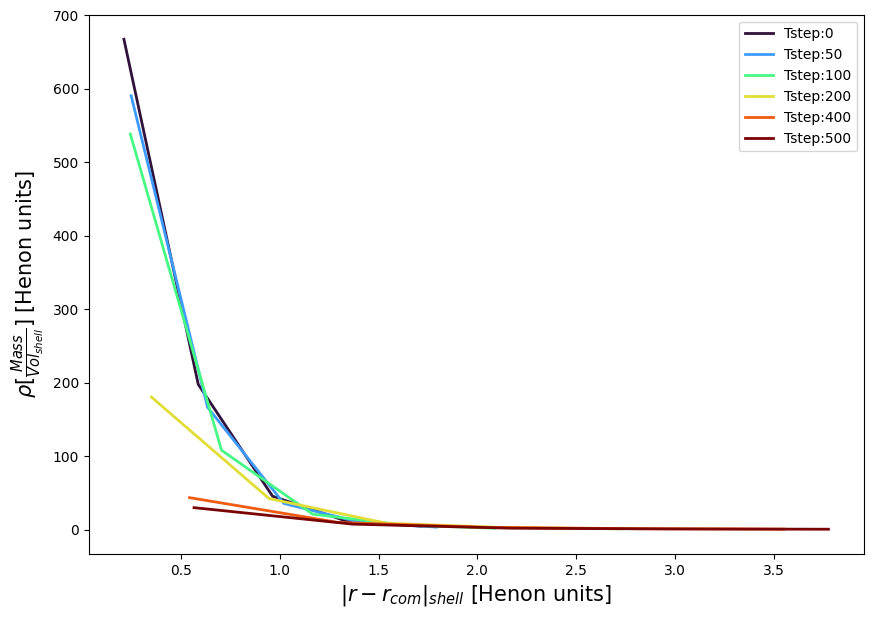

In [9]:
n_bins=5

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot()
important_time = [0, 50, 100, 200, 400, 500]
color = cm.turbo(np.linspace(0, 1, len(important_time)))

for k, c in enumerate(color):
    time = important_time[k]
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    counts, bin_edges = np.histogram(radius_snapshot, bins=n_bins)
    Vol_shell = 4/3 *np.pi* (bin_edges[1:]**3 - bin_edges[:-1]**3)
    density = counts / Vol_shell
    radius_shell = 1/2 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.plot(radius_shell, density, color=c, label=f'Tstep:{time}', linewidth=2)
    ax.set_xlabel(r'|$r - r_{com}|_{shell}$ [Henon units]', fontsize=15)
    ax.set_ylabel(r'$\rho [\frac{Mass}{Vol_{shell}}]$ [Henon units]', fontsize=15)
    ax.legend(loc='upper right', fontsize=10)
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/Density_profile_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

## Velocity dispersion of the velocity inside the r_h

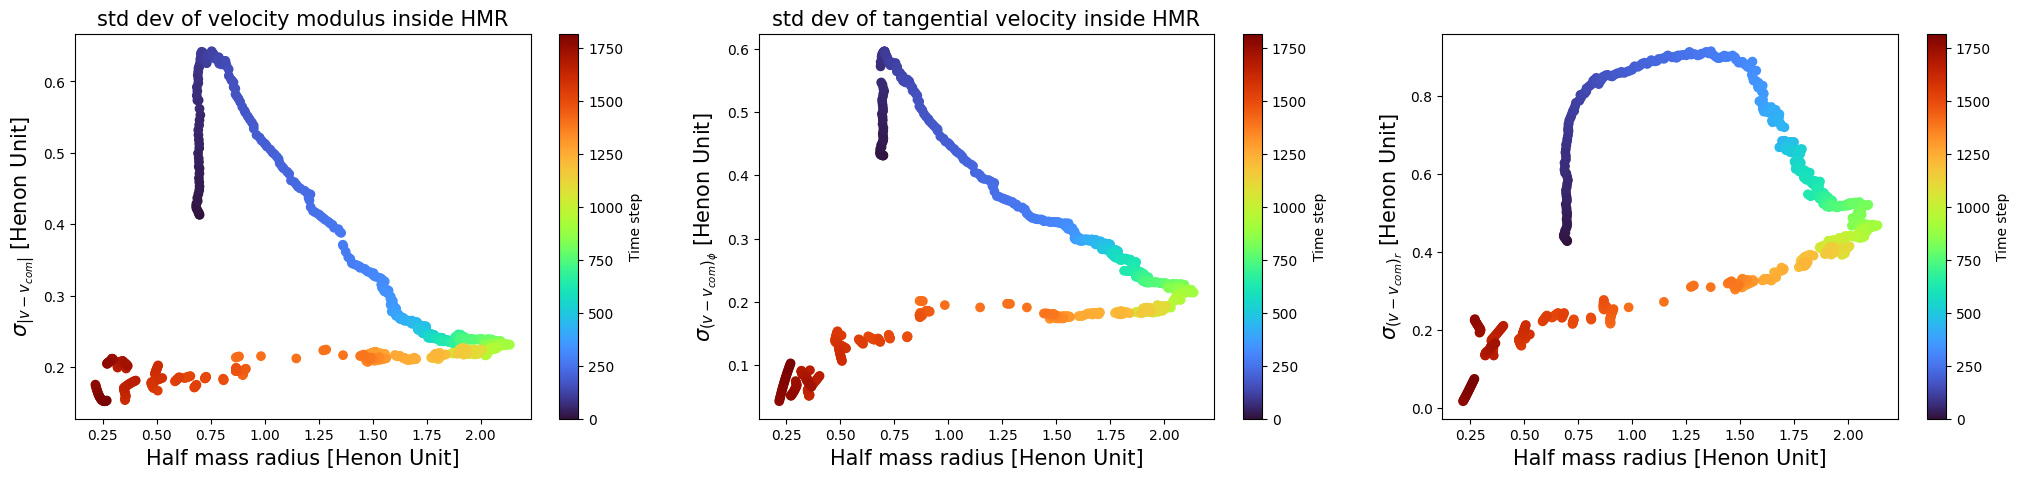

In [10]:
fig = plt.figure(figsize=(25, 5))
cmap = mpl.colormaps['turbo']
important_time = np.arange(0, len(position_comFoR), 2)
n_bins=10


velocity_dispersion_half_mass_radius = []
half_mass_radius_list = []
time_list = []

ax = fig.add_subplot(1,3,1)
for k, time in enumerate(important_time):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    if np.sort(radius_snapshot).shape[0]<1:
        break
    half_mass_radius = np.sort(radius_snapshot)[int(len(radius_snapshot)/2)]
    
    vel_snapshot = velocity[time][flag_history[time]]-np.linalg.norm(vel_com_history[time]) #- vel_com_history[time]
    vel_modul_snapshot = np.linalg.norm(vel_snapshot, axis=1)
    
    vel_half_mass_radius =  vel_modul_snapshot[np.argsort(radius_snapshot)]
    vel_half_mass_radius =  vel_half_mass_radius[:int(len(vel_half_mass_radius/2))]
    std_half_mass_radius = vel_half_mass_radius.std()
    velocity_dispersion_half_mass_radius.append(std_half_mass_radius)
    half_mass_radius_list.append(half_mass_radius)
    time_list.append(time)
    
pcm = ax.scatter(half_mass_radius_list, velocity_dispersion_half_mass_radius, label=f'Time: {time}', c=time_list, cmap=cmap)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Time step',  fontsize=10)
ax.set_xlabel('Half mass radius [Henon Unit]', fontsize=15)
ax.set_ylabel(r'$\sigma_{|v - v_{com}|}$ [Henon Unit]',  fontsize=15)
ax.set_title(r'std dev of velocity modulus inside HMR', fontsize=15)


velocity_dispersion_half_mass_radius = []
half_mass_radius_list = []
time_list = []

ax = fig.add_subplot(1,3,2)
for k, time in enumerate(important_time):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    if np.sort(radius_snapshot).shape[0]<1:
        break
    half_mass_radius = np.sort(radius_snapshot)[int(len(radius_snapshot)/2)]
    
    vel_wrt_com = velocity[time][flag_history[time]]- vel_com_history[time] #- vel_com_history[time]
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][flag_history[time]], vel_wrt_com[:, :])
    
    vel_half_mass_radius =  vel_phi[np.argsort(radius_snapshot)]
    vel_half_mass_radius =  vel_half_mass_radius[:int(len(vel_half_mass_radius/2))]
    std_half_mass_radius = vel_half_mass_radius.std()
    velocity_dispersion_half_mass_radius.append(std_half_mass_radius)
    half_mass_radius_list.append(half_mass_radius)
    time_list.append(time)
    
pcm = ax.scatter(half_mass_radius_list, velocity_dispersion_half_mass_radius, label=f'Time: {time}', c=time_list, cmap=cmap)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Time step',  fontsize=10)
ax.set_xlabel('Half mass radius [Henon Unit]', fontsize=15)
ax.set_ylabel(r'$\sigma_{{(v - v_{com})}_{\phi}}$ [Henon Unit]', fontsize=15)
ax.set_title(r'std dev of tangential velocity inside HMR', fontsize=15)



velocity_dispersion_half_mass_radius = []
half_mass_radius_list = []
time_list = []

ax = fig.add_subplot(1,3,3)
for k, time in enumerate(important_time):
    position_comFoR_flagged = position_comFoR[time][flag_history[time]]
    radius_snapshot = np.linalg.norm(position_comFoR_flagged, axis=1)
    if np.sort(radius_snapshot).shape[0]<1:
        break
    half_mass_radius = np.sort(radius_snapshot)[int(len(radius_snapshot)/2)]
    
    vel_wrt_com = velocity[time][flag_history[time]]- vel_com_history[time] #- vel_com_history[time]
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][flag_history[time]], vel_wrt_com[:, :])
    
    vel_half_mass_radius =  vel_r[np.argsort(radius_snapshot)]
    vel_half_mass_radius =  vel_half_mass_radius[:int(len(vel_half_mass_radius/2))]
    std_half_mass_radius = vel_half_mass_radius.std()
    velocity_dispersion_half_mass_radius.append(std_half_mass_radius)
    half_mass_radius_list.append(half_mass_radius)
    time_list.append(time)
    
pcm = ax.scatter(half_mass_radius_list, velocity_dispersion_half_mass_radius, label=f'Time: {time}', c=time_list, cmap=cmap)
cbar = fig.colorbar(pcm, ax=ax)
cbar.set_label('Time step',  fontsize=10)
ax.set_xlabel('Half mass radius [Henon Unit]',  fontsize=15)
ax.set_ylabel(r'$\sigma_{{(v - v_{com})}_r}$ [Henon Unit]',  fontsize=15)
# ax.set_title(r'std dev of radial velocity inside HMR', fontsize=15)
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/Velocity_dispersion_halfmass_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

# Orbit of the two center of mass (true vs iterative) 

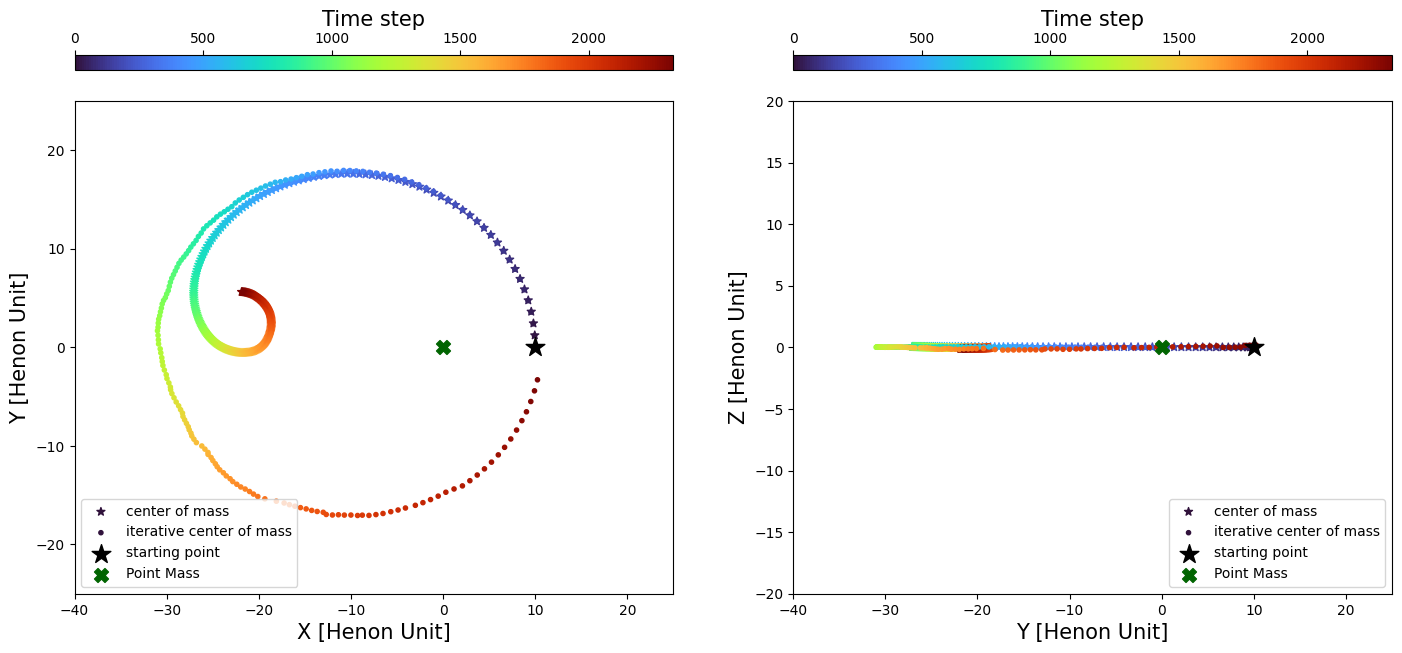

In [11]:
m = 10
cmap = plt.colormaps['turbo']
cmap2 = plt.colormaps['viridis']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), m)

fig = plt.figure(figsize=(17, 8))
ax = fig.add_subplot(121)
pcm = ax.scatter(position[::m, :, 0].mean(axis=1), position[::m, :, 1].mean(axis=1), c=step,  marker='*', label='center of mass', cmap=cmap)
ax.scatter(com_history[::m, 0], com_history[::m, 1], c=step, marker='.', label='iterative center of mass', cmap=cmap)
ax.scatter(position[0, :, 0].mean(), position[0, :, 1].mean(), marker='*', s=200, label='starting point', color='black')
ax.scatter(0, 0, s=100, label='Point Mass', color='darkgreen', marker='X')
cbar = fig.colorbar(pcm, ax=ax, location='top', aspect=40)
cbar.set_label(r'Time step',fontsize=15)
ax.set_xlim(-semi_major_axis*2, semi_major_axis+5)
ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
ax.set_xlabel('X [Henon Unit]', fontsize=15)
ax.set_ylabel('Y [Henon Unit]', fontsize=15)
ax.legend(loc='lower left')

ax2 = fig.add_subplot(122)
pcm=ax2.scatter(position[::m, :, 0].mean(axis=1), position[::m, :, 2].mean(axis=1), c=step,  marker='*', label='center of mass', cmap=cmap)
ax2.scatter(com_history[::m, 0], com_history[::m, 2], c=step, marker='.', label='iterative center of mass', cmap=cmap)
ax2.scatter(position[0, :, 0].mean(), position[0, :, 2].mean(), marker='*', s=200, label='starting point', color='black')
cbar = fig.colorbar(pcm, ax=ax2, location='top', aspect=40)
cbar.set_label(r'Time step', fontsize=15)
ax2.scatter(0, 0, s=100, label='Point Mass', color='darkgreen', marker='X')
ax2.set_xlabel('Y [Henon Unit]', fontsize=15)
ax2.set_ylabel('Z [Henon Unit]', fontsize=15)
ax2.set_xlim(-semi_major_axis*2, semi_major_axis+5)
ax2.set_ylim(-semi_major_axis, semi_major_axis)
ax2.legend(loc='lower right')
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/Orbit_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

# Projection on two planes (X vs Y) and (X vs Z)

## Projection of all the particles

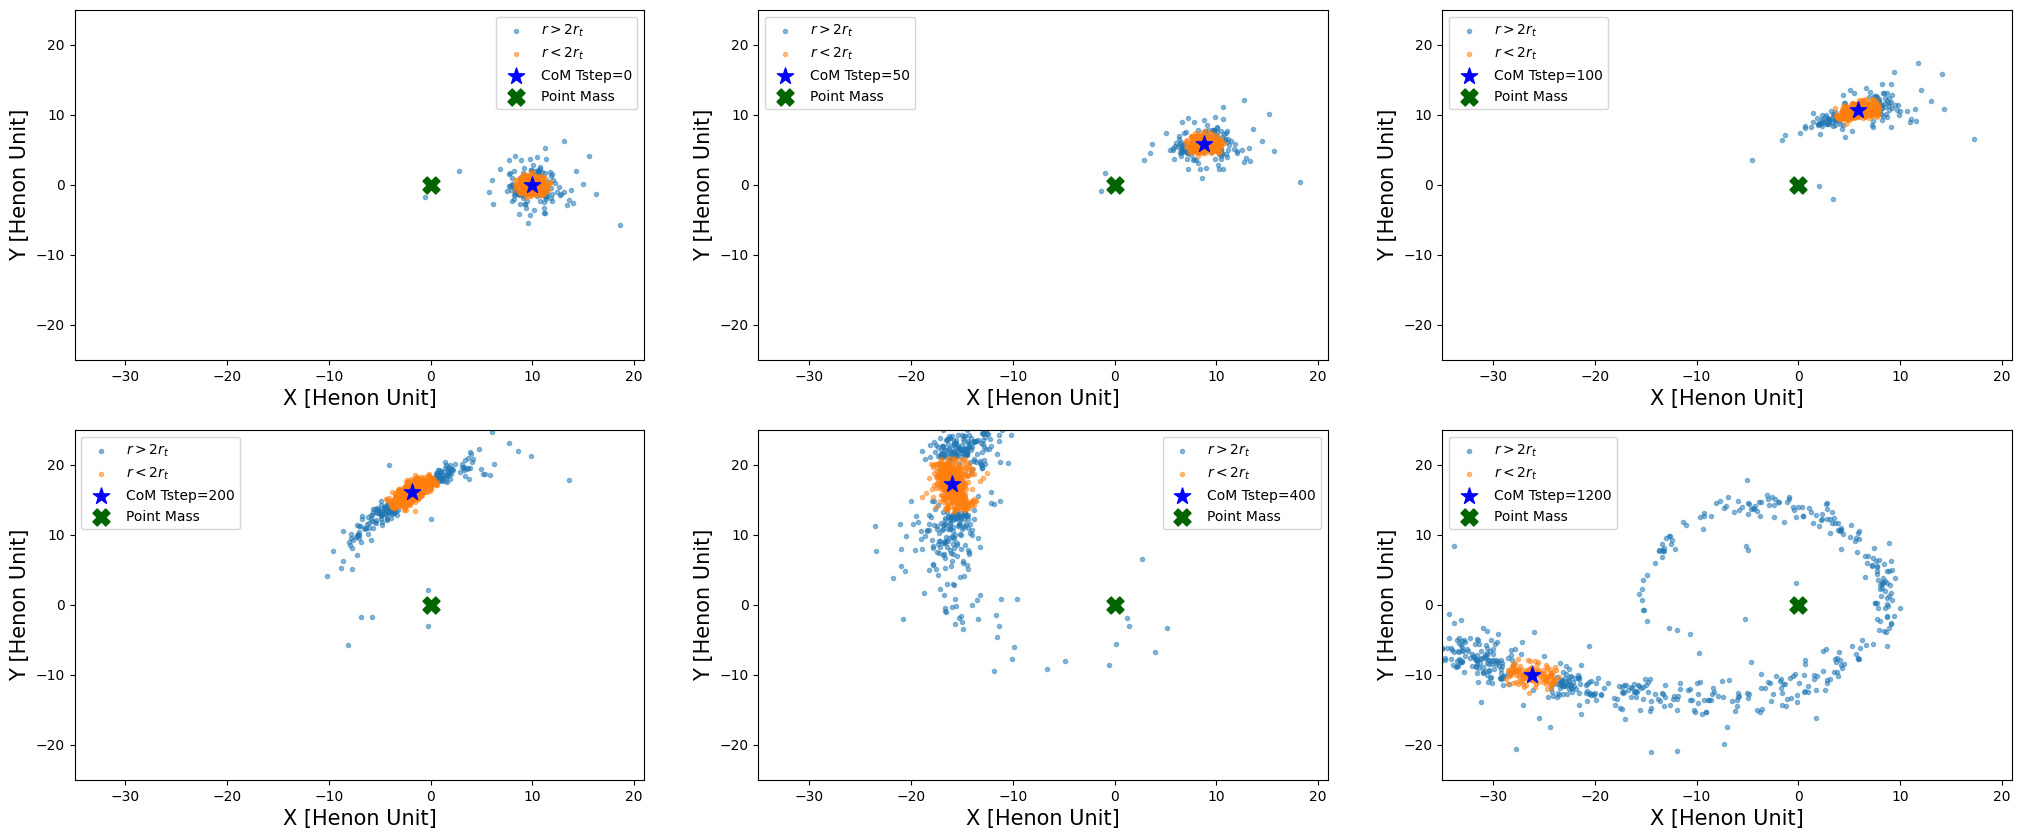

In [13]:
important_time = [0, 50, 100, 200, 400, 1200]
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)

fig = plt.figure(figsize=(25, 10))
for k, time in enumerate(important_time): 
    flag = flag_history[time]
    no_flag = ~flag
    ax = fig.add_subplot(2, 3, k+1)

    ax.scatter(position[time, :, 0][no_flag], position[time, :, 1][no_flag],  marker='.', label=r'$r>2r_t$', zorder=-100, alpha=0.5)
    ax.scatter(position[time, :, 0][flag], position[time, :, 1][flag],  marker='.', label=r'$r<2r_t$', zorder=100, alpha=0.5)
    ax.scatter(com_history[time, 0], com_history[time, 1],  marker='*', s=150, label=f'CoM Tstep={time}', c='blue', zorder=100)
    ax.scatter(0,0, c='darkgreen', marker='X', s=150, label='Point Mass')
    ax.set_xlim(-semi_major_axis-1.5*initial_position, semi_major_axis+1)
    ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
    ax.set_xlabel('X [Henon Unit]', fontsize=15)
    ax.set_ylabel('Y [Henon Unit]', fontsize=15)
    ax.legend()
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/ProjectionXY_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

# Density plot on X, Y of the stellar stream

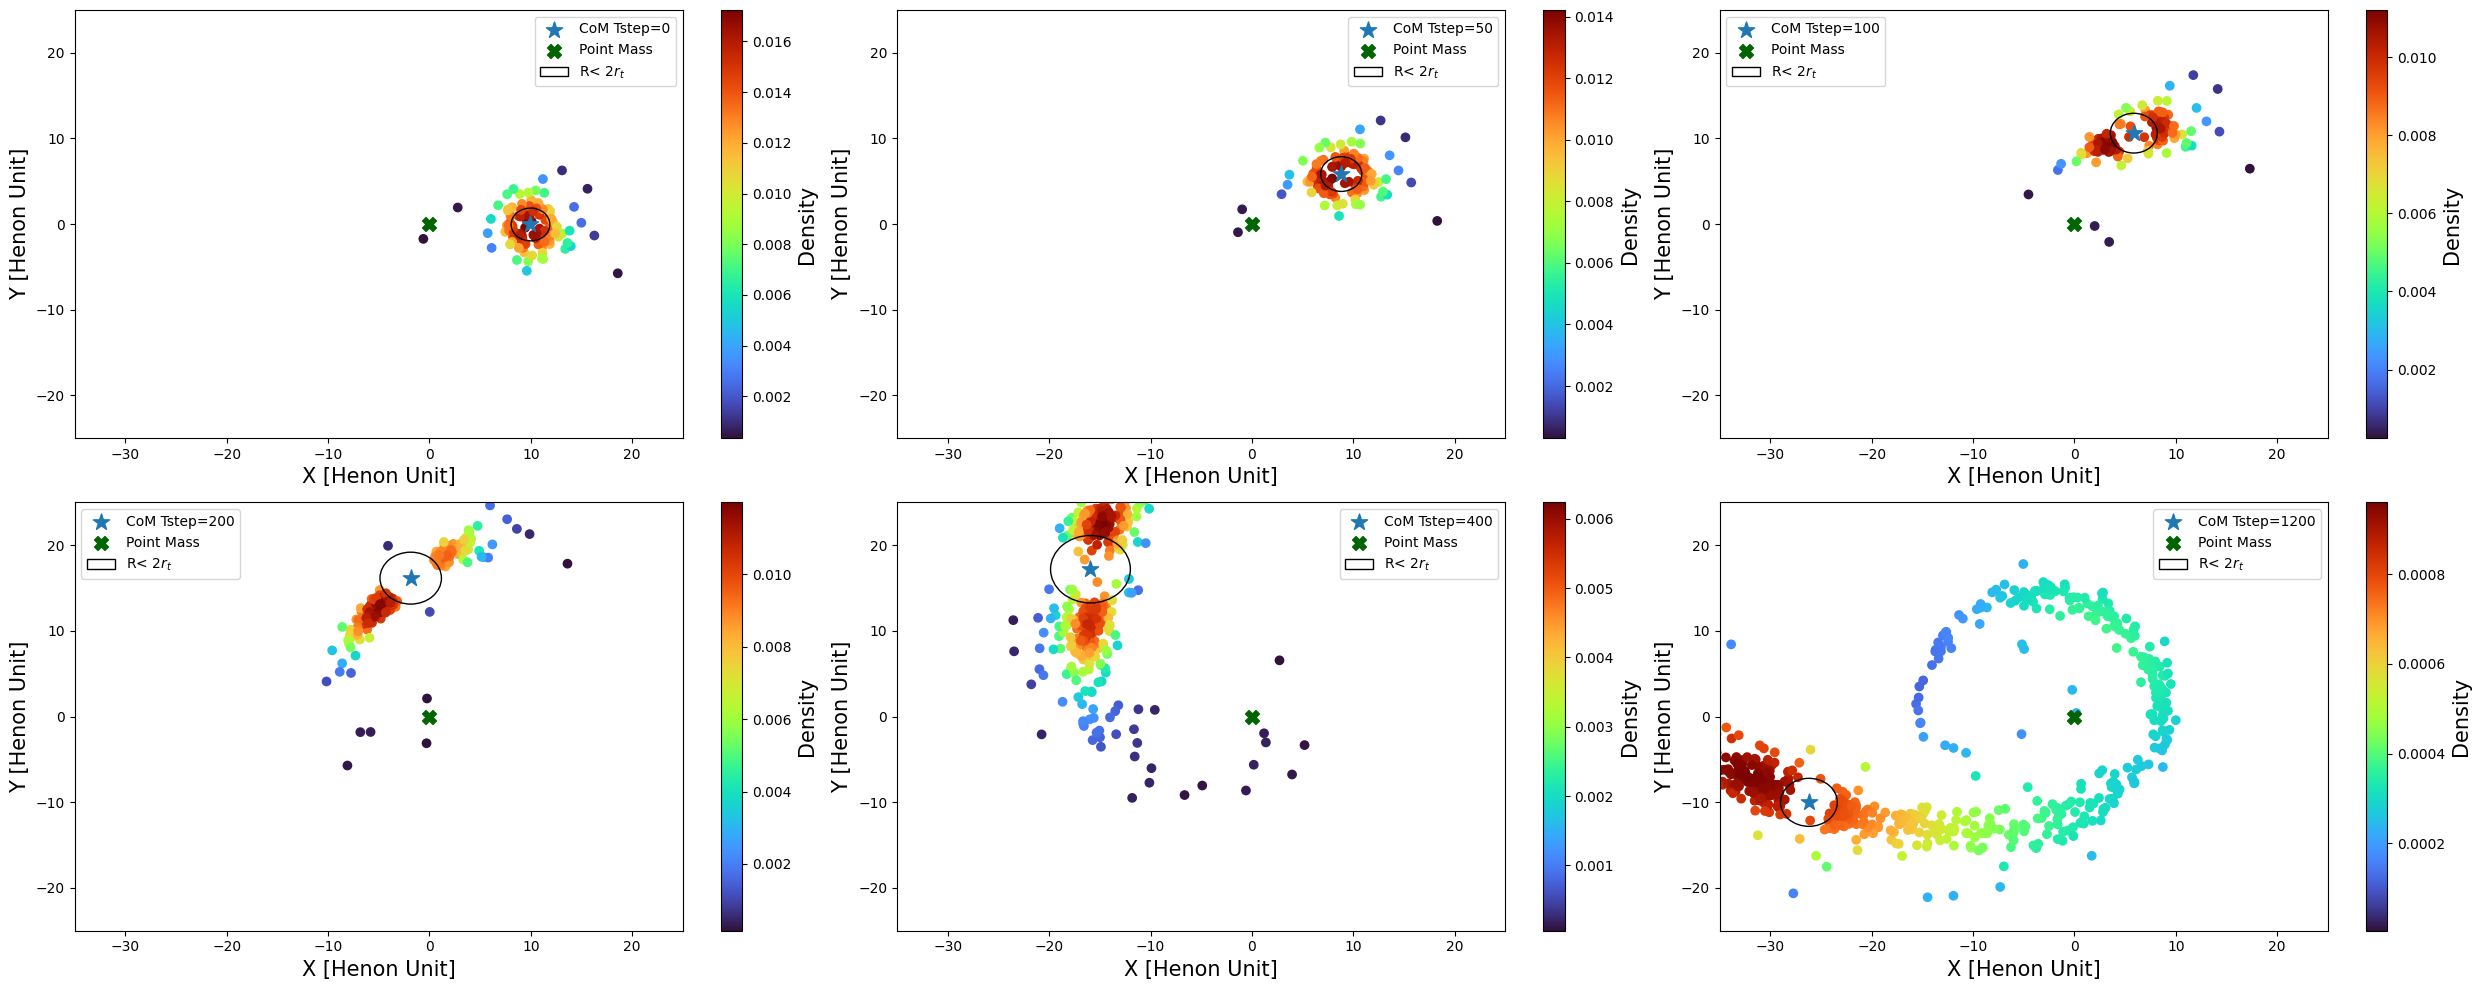

In [14]:
important_time = [0, 50, 100, 200, 400, 1200]
fig=plt.figure(figsize=(25, 10), layout='tight')
for i, time in enumerate(important_time):
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='black', fill=False, label=r'R< $2r_t$')
    flag=flag_history[time]
    no_flag=~flag
    X = np.stack((position[time, :, 0][no_flag], position[time, :, 1][no_flag], np.zeros_like(position[time, :, 1][no_flag])), axis=1)

    xy = np.vstack([X[:,0], X[:,1]])
    z = gaussian_kde(xy)(xy)
    cov = gaussian_kde(xy).covariance
    

    ax = fig.add_subplot(2, 3, i+1)
    pcm = ax.scatter(X[:, 0], X[:, 1], c=z, cmap=cmap)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('Density', fontsize=15)
    ax.scatter(com_history[time, 0], com_history[time, 1],  marker='*', s=150, label=f'CoM Tstep={time}', zorder=100)
    ax.scatter(0, 0, s=100, label='Point Mass', color='darkgreen', marker='X')
    ax.add_patch(circle)
    ax.set_xlim(-semi_major_axis-1.5*initial_position, semi_major_axis+5)
    ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
    ax.set_xlabel('X [Henon Unit]', fontsize=15)
    ax.set_ylabel('Y [Henon Unit]', fontsize=15)
    ax.legend()
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/Tidal_stream_density_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

# Tangential velocity of all stars w.r.t. the Com 

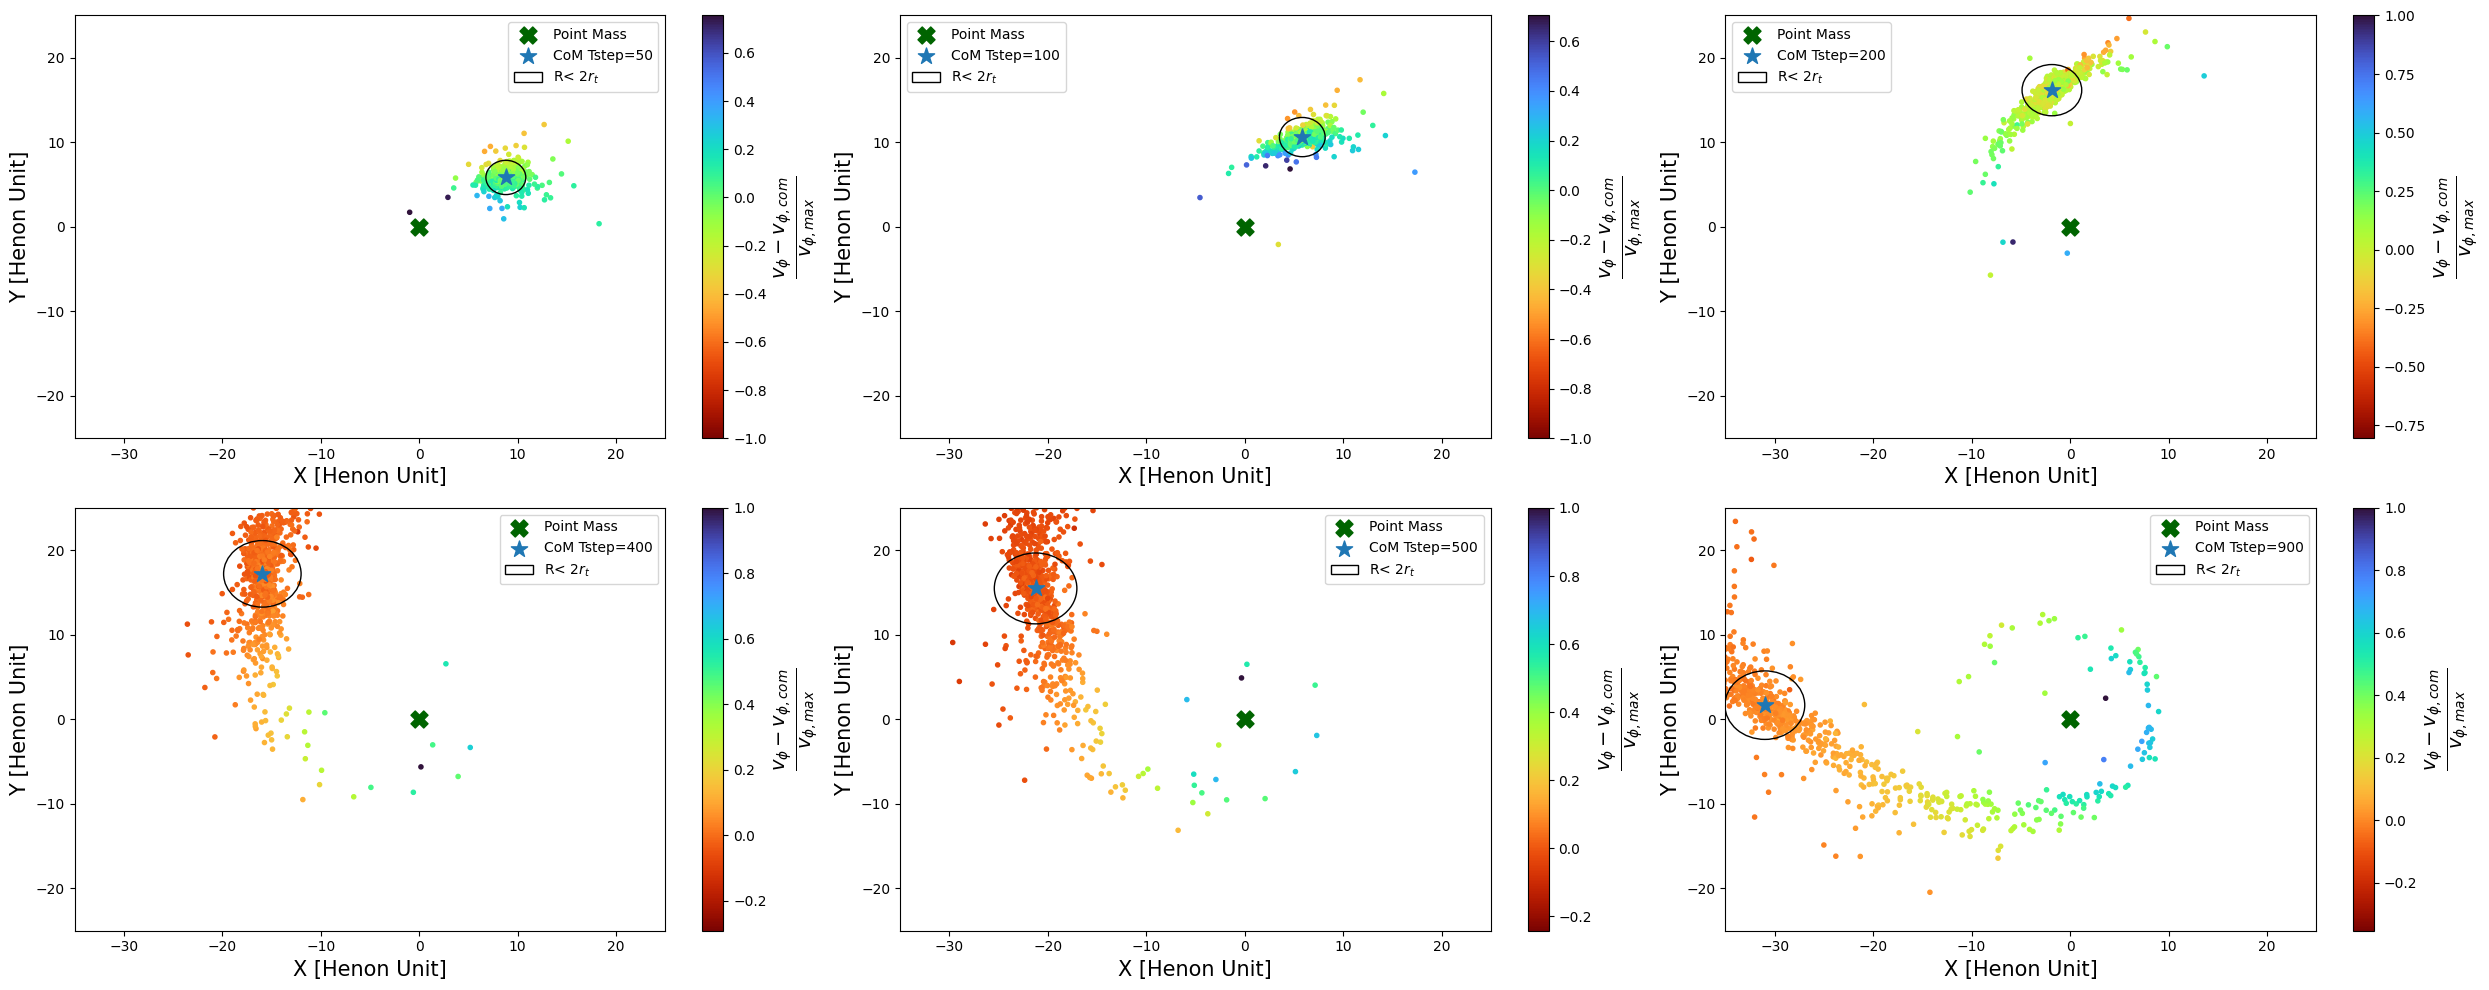

In [15]:
important_time = [50, 100, 200, 400, 500, 900]
cmap = plt.colormaps['turbo_r']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)

fig = plt.figure(layout='tight', figsize=(25,10))
for k, time in enumerate(important_time): 
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='black', fill=False, label=r'R< $2r_t$')


    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time, :, :], velocity[time, :, :])
    rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])
    vel_wrt_com = vel_phi - vel_phi_com

    mask_on_vel = ((vel_wrt_com/np.abs(vel_wrt_com).max()) > -0.5)
    
    ax = fig.add_subplot(2, 3, k+1)
    ax.scatter(0,0, c='darkgreen', marker='X', label='Point Mass', s=150)
    ax.scatter(com_history[time, 0], com_history[time, 1],  marker='*', s=150, label=f'CoM Tstep={time}', zorder=100)
    pcm = ax.scatter(position[time, :, 0][mask_on_vel], position[time, :, 1][mask_on_vel], c=vel_wrt_com[mask_on_vel]/np.abs(vel_wrt_com[mask_on_vel]).max(), marker='.', cmap=cmap)
    ax.add_patch(circle)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$\frac{v_\phi - v_{\phi, com}}{v_{\phi,max}}$', fontsize=20)
    ax.set_xlim(-semi_major_axis-1.5*initial_position, semi_major_axis+5)
    ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)

    ax.set_xlabel('X [Henon Unit]', fontsize=15)
    ax.set_ylabel('Y [Henon Unit]', fontsize=15)
    ax.legend()
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/TanVel_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

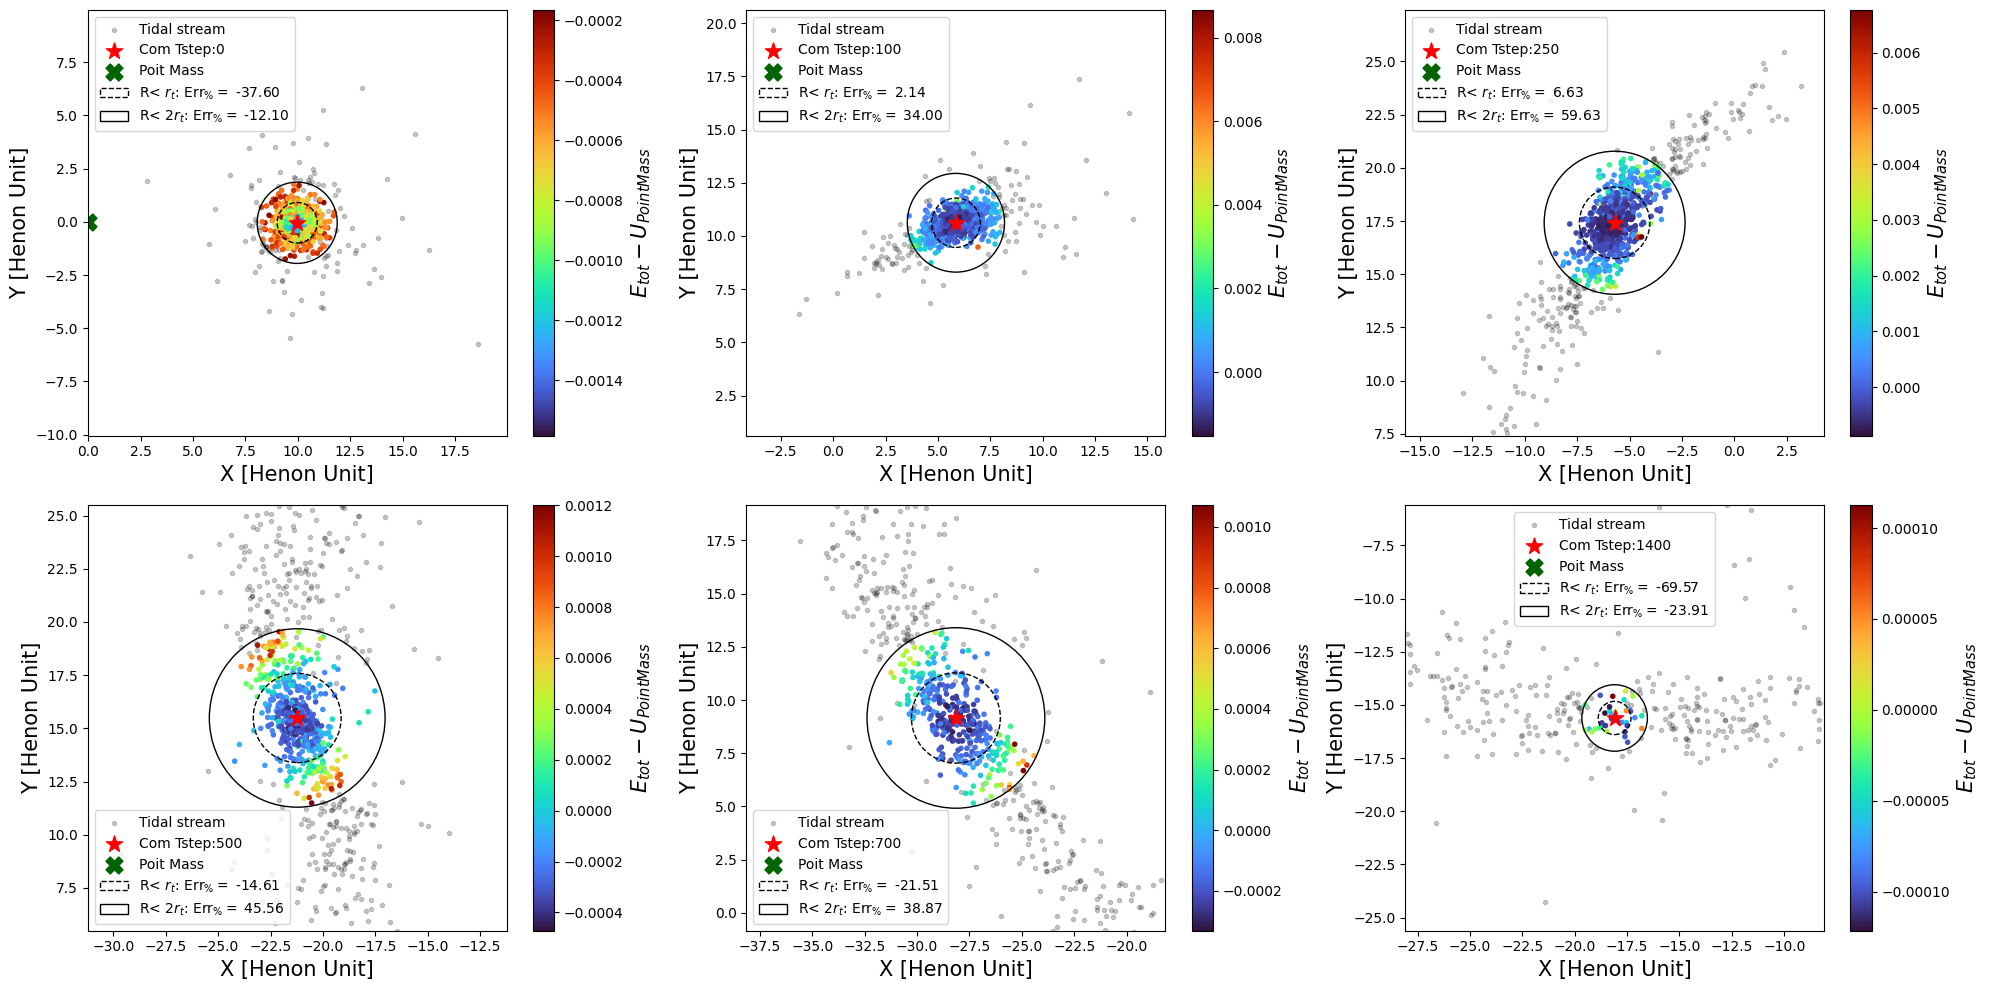

In [16]:
cmap = plt.colormaps['turbo']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)
important_time = [0, 100, 250, 500,  700, 1400]

fig = plt.figure(layout='tight', figsize=(20,10))
for k, time in enumerate(important_time): 
    
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time, :, :][flag_history[time]], velocity[time, :, :][flag_history[time]])
    rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])  
    vel_phi_wrt_com = vel_phi - vel_phi_com
    vel_rho_wrt_com = vel_r - vel_r_com
    E_kin = 0.5*(1/N)*np.linalg.norm(velocity[time, :, :][flag_history[time]] - vel_com_history[time], axis=1)**2
    E_pot = (1/N)*potential[time][flag_history[time]]
    E_tot = E_kin + E_pot


    E_kin_err = 0.5*(1/N)*np.linalg.norm(velocity[time, :, :] - vel_com_history[time], axis=1)**2
    E_pot_err = (1/N)*potential[time]
    E_tot_err =E_kin_err + E_pot_err 
    
    ax = fig.add_subplot(2, 3, k+1)

    pcm = ax.scatter(position[time, :, 0][~flag_history[time]], 
                     position[time, :, 1][~flag_history[time]],  
                     c='black', alpha=0.2, marker='.', label='Tidal stream', zorder=0)
    pcm = ax.scatter(position[time, :, 0][flag_history[time]], 
                     position[time, :, 1][flag_history[time]],  
                     c=E_tot,  marker='.', cmap=cmap)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$E_{tot} - U_{Point Mass}$', fontsize=15)

    ax.scatter(com_history[time][0], com_history[time][1], marker='*', s=150, c='r', label=f'Com Tstep:{time}')
    ax.scatter(0,0, marker='X', color='darkgreen', label='Poit Mass', s=150)

    count_E = len(E_tot_err[E_tot_err<0])
    count_rt = len(position[time][np.linalg.norm(position[time] - com_history[time], axis=1)< tidal2_history[time]/2])
    count_2rt = len(position[time][np.linalg.norm(position[time] - com_history[time], axis=1)< tidal2_history[time]])
    error_rt = (- count_E + count_rt)/count_E
    error_2rt = (- count_E + count_2rt)/count_E
    
    circle_1 = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time]/2, color='black', fill=False, linestyle='--', label=r'R< $r_t$'+ r': Err$_{\%}=$ ' + f'{error_rt*100:.2f}')
    circle_2 = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='black', fill=False, linestyle='-', label=r'R< $2r_t$'+ r': Err$_{\%}=$ ' + f'{error_2rt*100:.2f}')
    ax.add_patch(circle_1)
    ax.add_patch(circle_2)
    
    ax.set_xlabel('X [Henon Unit]', fontsize=15)
    ax.set_ylabel('Y [Henon Unit]', fontsize=15)
    ax.set_xlim(com_history[time][0]-10,  com_history[time][0]+10)
    ax.set_ylim(com_history[time][1]-10,  com_history[time][1]+10)
    ax.legend()
    fig.show()
    
# fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/EtotPlummer_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

In [17]:
cmap = plt.colormaps['turbo']
com_history = np.array(com_history)
step = np.arange(0, len(com_history), 1)
important_time = [0, 100, 250, 500,  700, 1400]
list_err_rt = []
list_err_2rt = []

fig = plt.figure(layout='tight', figsize=(20,10))
for k, time in enumerate(range(len(position))): 
    if isnan(com_history[time][0]):
        break
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time, :, :][flag_history[time]], velocity[time, :, :][flag_history[time]])
    rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])  
    vel_phi_wrt_com = vel_phi - vel_phi_com
    vel_rho_wrt_com = vel_r - vel_r_com
    E_kin = 0.5*(1/N)*np.linalg.norm(velocity[time, :, :][flag_history[time]] - vel_com_history[time], axis=1)**2
    E_pot = (1/N)*potential[time][flag_history[time]]
    E_tot = E_kin + E_pot


    E_kin_err = 0.5*(1/N)*np.linalg.norm(velocity[time, :, :] - vel_com_history[time], axis=1)**2
    E_pot_err = (1/N)*potential[time]
    E_tot_err = E_kin_err + E_pot_err 
    

    count_E = len(E_tot_err[E_tot_err<0])
    count_rt = len(position[time][np.linalg.norm(position[time] - com_history[time], axis=1)< tidal2_history[time]/2])
    count_2rt = len(position[time][np.linalg.norm(position[time] - com_history[time], axis=1)< tidal2_history[time]])
    error_rt = (- count_E + count_rt)/count_E
    error_2rt = (- count_E + count_2rt)/count_E

    list_err_rt.append(error_rt)
    list_err_2rt.append(error_2rt)
    
# fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/EtotPlummer_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

<Figure size 2000x1000 with 0 Axes>

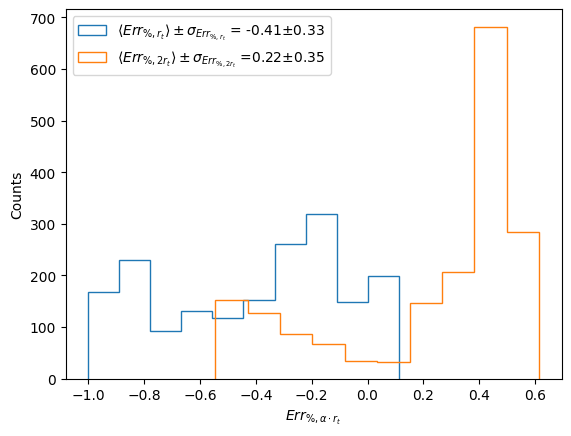

In [18]:
list_err_rt = np.array(list_err_rt)
list_err_2rt = np.array(list_err_2rt)

plt.hist(list_err_rt, label=r'$\left< Err_{\%, r_{t}} \right> \pm \sigma_{Err_{\%, r_{t}}}$ = '+f'{list_err_rt.mean() :.2f}' + r'$\pm$' + f'{list_err_rt.std():.2f}', fill=False, histtype='step')
plt.hist(list_err_2rt, label=r'$\left< Err_{\%, 2r_{t}} \right> \pm \sigma_{Err_{\%, 2r_{t}}}$ ='+f'{list_err_2rt.mean() :.2f}' + r'$\pm$' + f'{list_err_2rt.std():.2f}', fill=False, histtype='step')
plt.legend()
plt.xlabel(r'$Err_{\%, \alpha \cdot r_{t}}$')
plt.ylabel('Counts')

plt.savefig(f'Images/{e}/EstimateError_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')

# Histogram to study the distribution of the tangential velocity of the trailing and leading arms

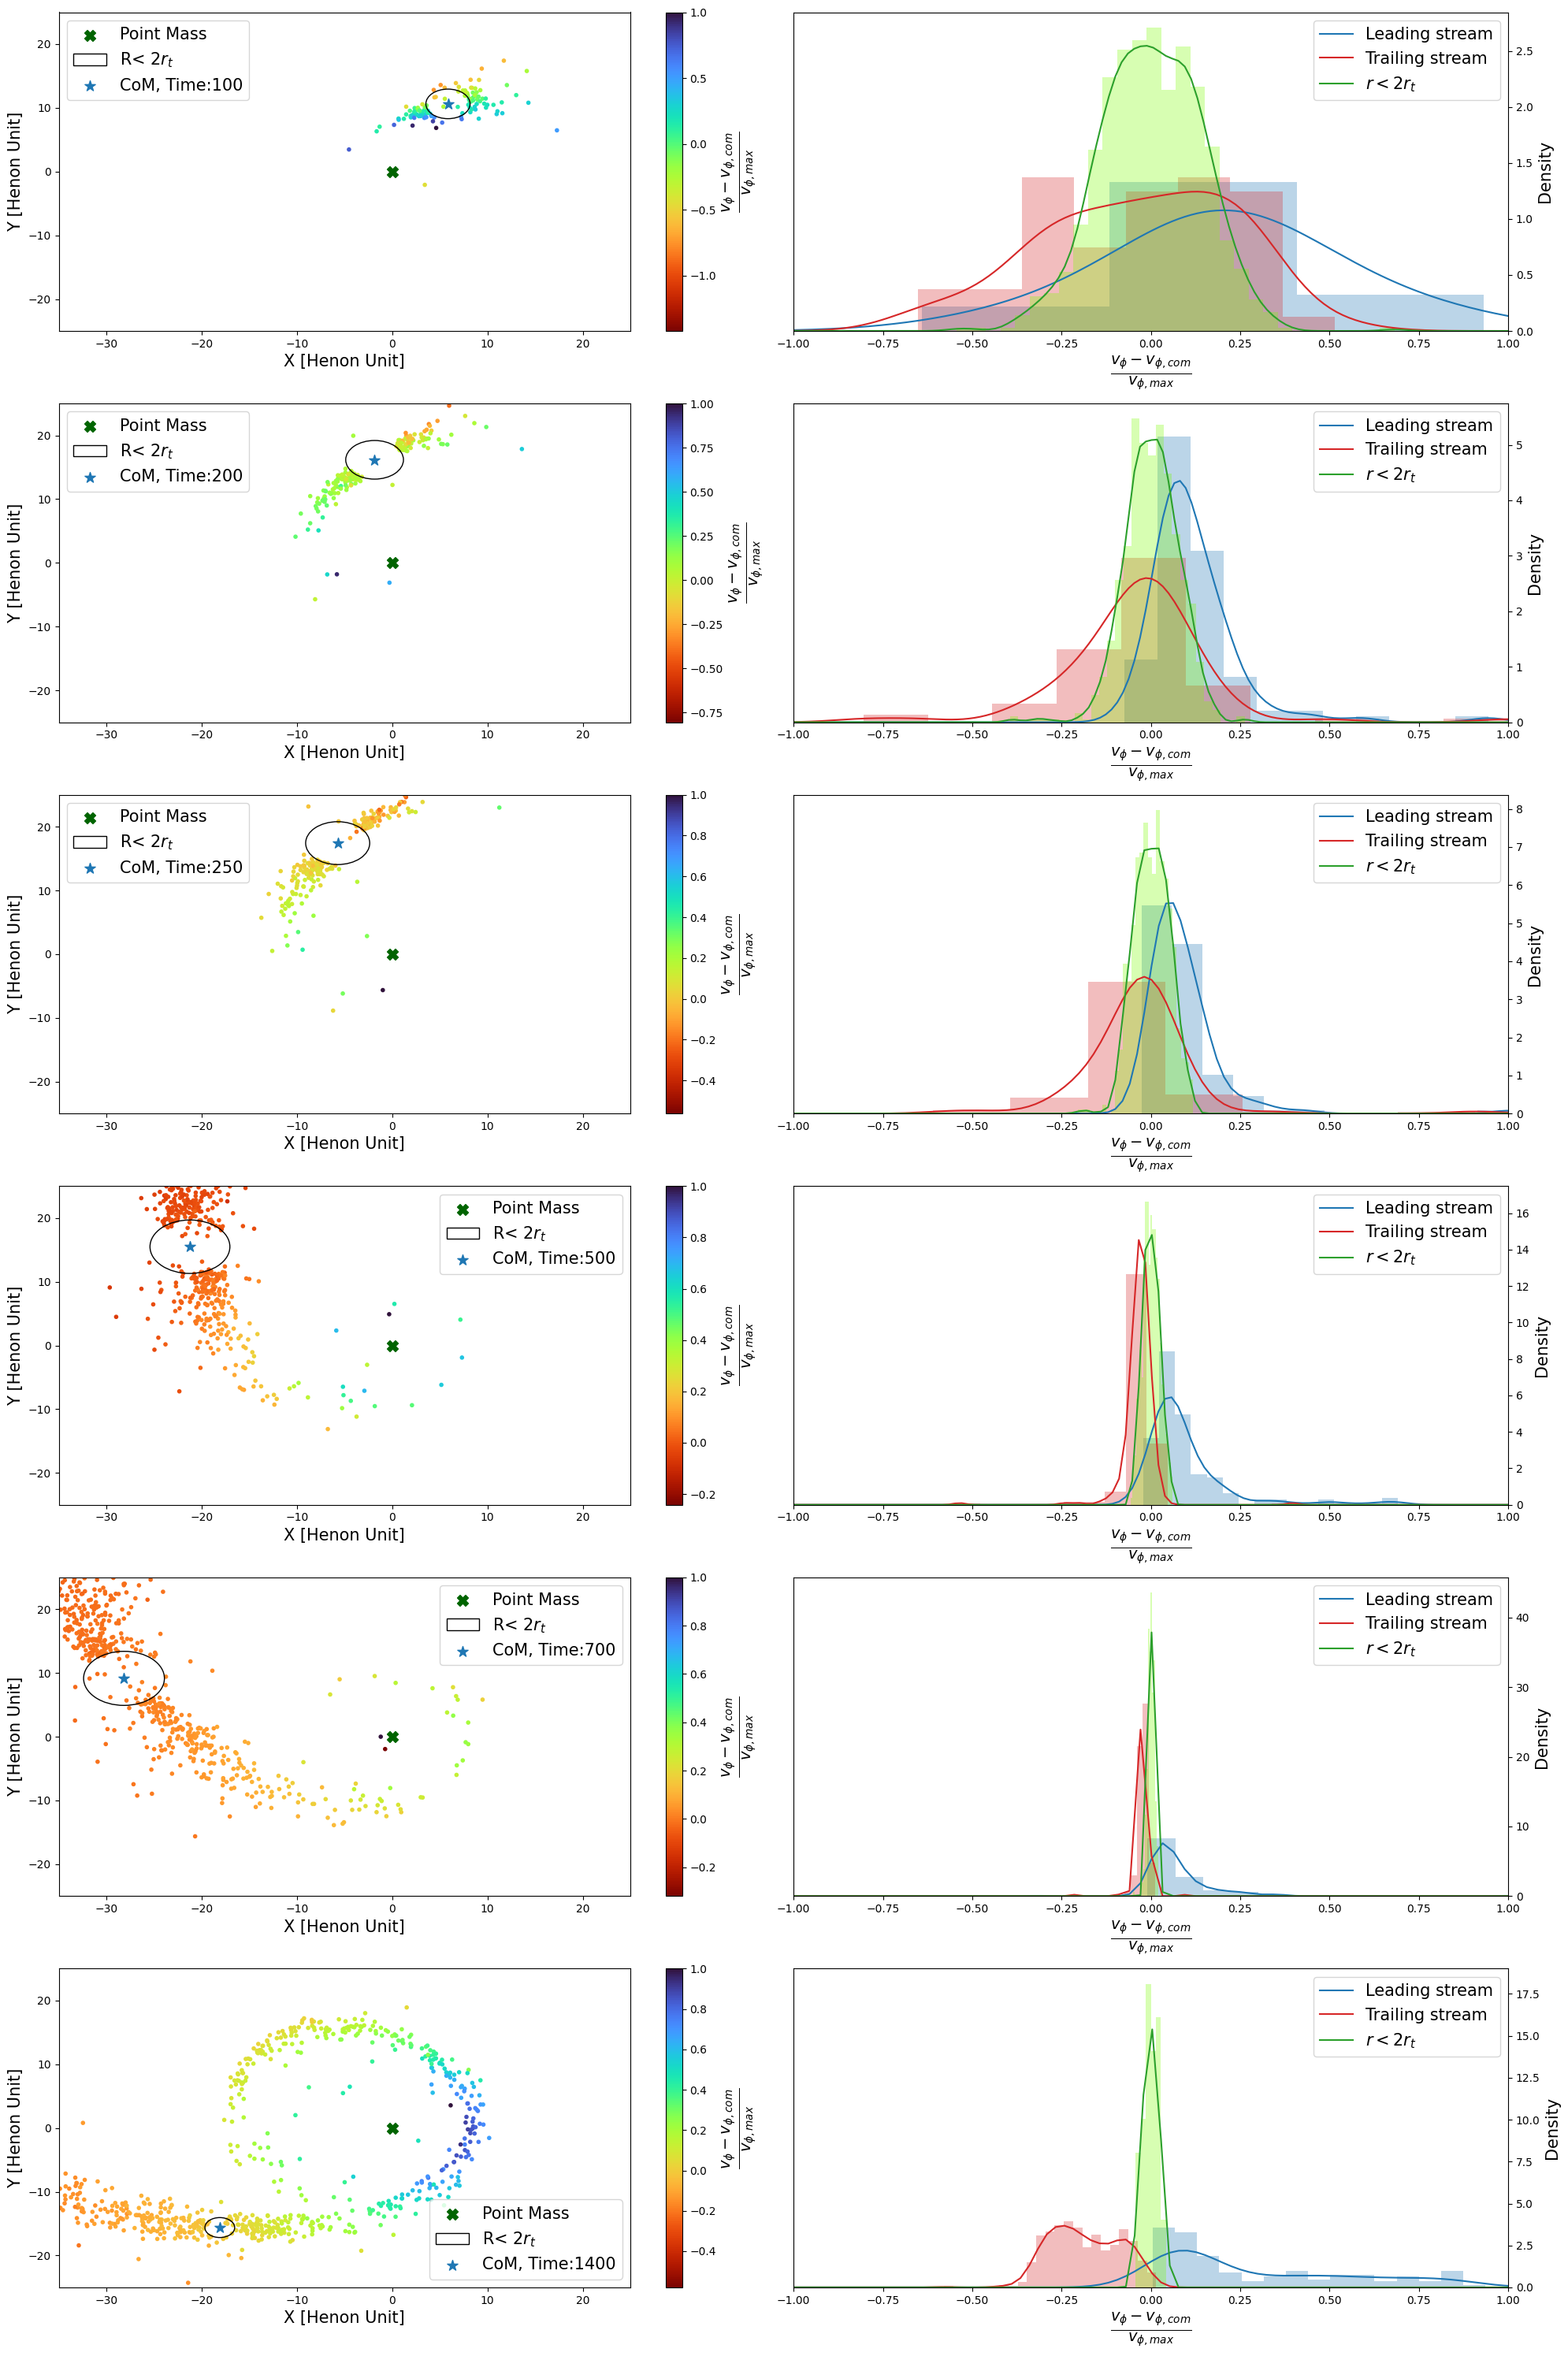

In [19]:
important_time = [100, 200, 250, 500, 700, 1400]
fig = plt.figure(figsize=(20, 30), layout='tight')
k=1
for time in important_time:
    cmap = plt.colormaps['turbo_r']
    flag=flag_history[time]
    no_flag=~flag
    
    
    
    rho_com, phi_com, vel_r_com, vel_phi_com, vel_z_com = cyl_coord(com_history[time], vel_com_history[time])
    rho, phi, vel_r, vel_phi, vel_z = cyl_coord(position[time][no_flag], velocity[time][no_flag])
    vel_wrt_com = vel_phi - vel_phi_com
    
    plummer_shpere, plummer_shpere_velocity = position[time][flag], velocity[time][flag]
    rho_plummer, phi_plummer, vel_r_plummer, vel_phi_plummer, vel_z_plummer = cyl_coord(plummer_shpere, plummer_shpere_velocity)
    vel_wrt_com_plummer = vel_phi_plummer - vel_phi_com

    mask_on_vel = ((vel_wrt_com/np.abs(vel_wrt_com).max()) > -0.5)
    circle = plt.Circle((com_history[time][0], com_history[time][1]), tidal2_history[time], color='black', fill=False, label=r'R< $2r_t$')

    
    ax = fig.add_subplot(len(important_time), 2, k)

    ax.scatter(0,0, label='Point Mass', s=100, color='darkgreen',  marker='X')
    pcm = ax.scatter(position[time][no_flag][mask_on_vel][:, 0], position[time][no_flag][mask_on_vel][:, 1],  c=vel_wrt_com[mask_on_vel]/vel_wrt_com.max(),  marker='.', cmap=cmap)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(r'$\frac{v_\phi - v_{\phi, com}}{v_{\phi,max}}$',  fontsize=20)
    ax.add_patch(circle)
    ax.scatter(com_history[time][0], com_history[time][1], marker='*', s=100, label=f'CoM, Time:{time}')
    ax.set_xlabel('X [Henon Unit]', fontsize=15)
    ax.set_ylabel('Y [Henon Unit]', fontsize=15)
    ax.set_xlim(-semi_major_axis-1.5*initial_position, semi_major_axis+5)
    ax.set_ylim(-semi_major_axis-5, semi_major_axis+5)
    ax.legend(fontsize=15)
    k+=1
    
    
    
    ax = fig.add_subplot(len(important_time), 2, k)
    ax.hist(vel_wrt_com[(phi-phi_com>0) & (rho-rho_com<0)]/vel_wrt_com.max(), bins= 'sqrt', density=True, color='tab:blue', alpha=0.3)
    ax.hist(vel_wrt_com[(phi-phi_com<0) & (rho-rho_com>0)]/vel_wrt_com.max(), bins='sqrt', density=True,color='tab:red', alpha=0.3)
    ax.hist(vel_wrt_com_plummer/vel_wrt_com.max(), bins='sqrt', density=True, color='lawngreen', alpha=0.3)
    
    density_high = gaussian_kde(vel_wrt_com[(phi-phi_com>0) & (rho-rho_com<0)]/vel_wrt_com.max())
    density_low = gaussian_kde(vel_wrt_com[(phi-phi_com<0) & (rho-rho_com>0)]/vel_wrt_com.max())
    density_plummer = gaussian_kde(vel_wrt_com_plummer/vel_wrt_com.max())
    x = np.linspace(vel_wrt_com.min(), vel_wrt_com.max(), 1000)
    ax.plot(x, density_high(x), label=r'Leading stream', color='tab:blue')
    ax.plot(x, density_low(x), label=r'Trailing stream', color='tab:red')
    ax.plot(x, density_plummer(x), label=r'$r < 2r_t$', color='tab:green')
    
    ax.set_xlabel(r'$\frac{v_\phi - v_{\phi, com}}{v_{\phi,max}}$', fontsize=20)
    ax.set_ylabel('Density',  fontsize=15)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.set_xlim(-1, 1)
    # ax.set_ylim(-0.1, 10)
    ax.legend(fontsize=15)
    k+=1
fig.savefig(fname=f'/ca23/ext_volume/pod_compastro23/Project/Images/{e}/HistTidalVel_{N}_InitialPos_{initial_position}_e_{e}.png', bbox_inches='tight')